In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from itertools import product

from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, learning_curve
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.experimental import enable_halving_search_cv, enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors

# A re-evaluation of the Stability graph for machine-learning-aided underground stope design

## Introduction

In continuation of the work, presented in the *'A Feasibility Study on The Implementation of Neural Network Classifiers for Open Stope Design'* paper by Adoko et al., a partial recreation of the code was utilized in the study. However, additional models were also examined, as well other predictors were used for a final evaluation of each model's performance.

Hence, the aim of this notebook is to expore the feasibility of using additional models and additional performance metrics for model selection, appling practical considerations related to safe mining conditions, and not solely on achieving the 'ultimately accurate' classifier.

For the purpose the following tasks were solved:
- Loading and pre-processing
- Exploratory data analysis (EDA) and Feature selection
- Training, testing and evaluating exemplary models (Softmax, Support vector machines, Multi-layer perceptron, KNN, Decision tree, Gradient-boosted decision trees and Random forests)

## Loading and preprocessing

The dataset is public and available on <https://link.springer.com/article/10.1007/s10706-021-01915-8/tables/11>

For ease of use, a .csv file is available in the folder.

In [2]:
df = pd.read_csv('stability_graph_dataset.csv', sep=';')
df.head(-5)

,Mine Portal,Level,Orebody Thickness,Stope Surface,Surface Dip,Height,Span,Length,HR,Q',A,B,C,N',Status
0,PAB,2000,11.9,Back,90,30.0,11.9,20.0,3.7,4.7,1.0,1.0,1.0,4.7,Unstable
1,PAB,2000,11.9,VerticalEnd,90,30.0,11.9,30.0,4.3,4.7,1.0,1.0,8.0,37.6,Stable
2,PAB,2000,11.9,HangingWall,90,30.0,20.0,30.0,6.0,1.5,1.0,0.5,8.0,6.0,Unstable
3,PAB,2000,11.9,FootWall,90,30.0,20.0,30.0,6.0,4.7,1.0,0.8,8.0,30.1,Stable
4,PAB,2000,22.3,Back,90,30.0,22.3,43.0,7.3,4.7,1.0,1.0,1.0,4.7,Unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,SAN,30L,17.1,FootWall,79,23.0,19.0,15.0,4.2,20.0,1.0,0.2,8.0,35.2,Stable
216,SAN,30L,5.9,FootWall,85,30.0,6.6,30.0,2.7,8.8,1.0,0.2,7.5,13.2,Stable
217,SAN,30L,5.9,HangingWall,85,30.0,6.6,30.0,2.7,3.5,1.0,0.2,7.5,5.3,Stable
218,SAN,30L,5.2,Back,90,11.0,5.8,36.0,1.9,20.0,1.0,0.2,2.0,8.0,Stable


Transformations using a $log_{10}$ base were applied for the $Q^{\prime}$ (rock mass quality index), $N^{\prime}$ (modified stability number) and $HR$ (hydraulic radius of the evaluated wall).

In [3]:
df["Q'_log10"] = np.log10(df["Q'"])
df["N'_log10"] = np.log10(df["N'"])
df["HR_log10"] = np.log10(df["HR"])
df[["Q'", "Q'_log10", "N'", "N'_log10", "HR", "HR_log10"]].head(5)

,Q',Q'_log10,N',N'_log10,HR,HR_log10
0,4.7,0.672098,4.7,0.672098,3.7,0.568202
1,4.7,0.672098,37.6,1.575188,4.3,0.633468
2,1.5,0.176091,6.0,0.778151,6.0,0.778151
3,4.7,0.672098,30.1,1.478566,6.0,0.778151
4,4.7,0.672098,4.7,0.672098,7.3,0.863323


For the sake of visualization, the following color pallete was employed for each of the three classes:
- Stable
- Unstable
- Caved

In [4]:
custom_palette = {"Stable": "tab:blue", "Unstable": "tab:green", "Caved": "tab:red"}

For the sake of usability, a list of all quantifiable features was made.

In [5]:
features_quant = [
    "Orebody Thickness",	
    "Stope Surface",
    "Surface Dip",
    "Height",
    "Span",
    "Length",
    "HR",
    "Q'_log10",
    "A",
    "B",
    "C",
    "N'_log10",
    "Status"
]

## Exploratory data analysis (EDA) and Feature selection

A pairplot is presented so as to see which pairs of features can easily separate the three classes. Additionally, the desnity of each class can be observed for each quantitative feature.

[]

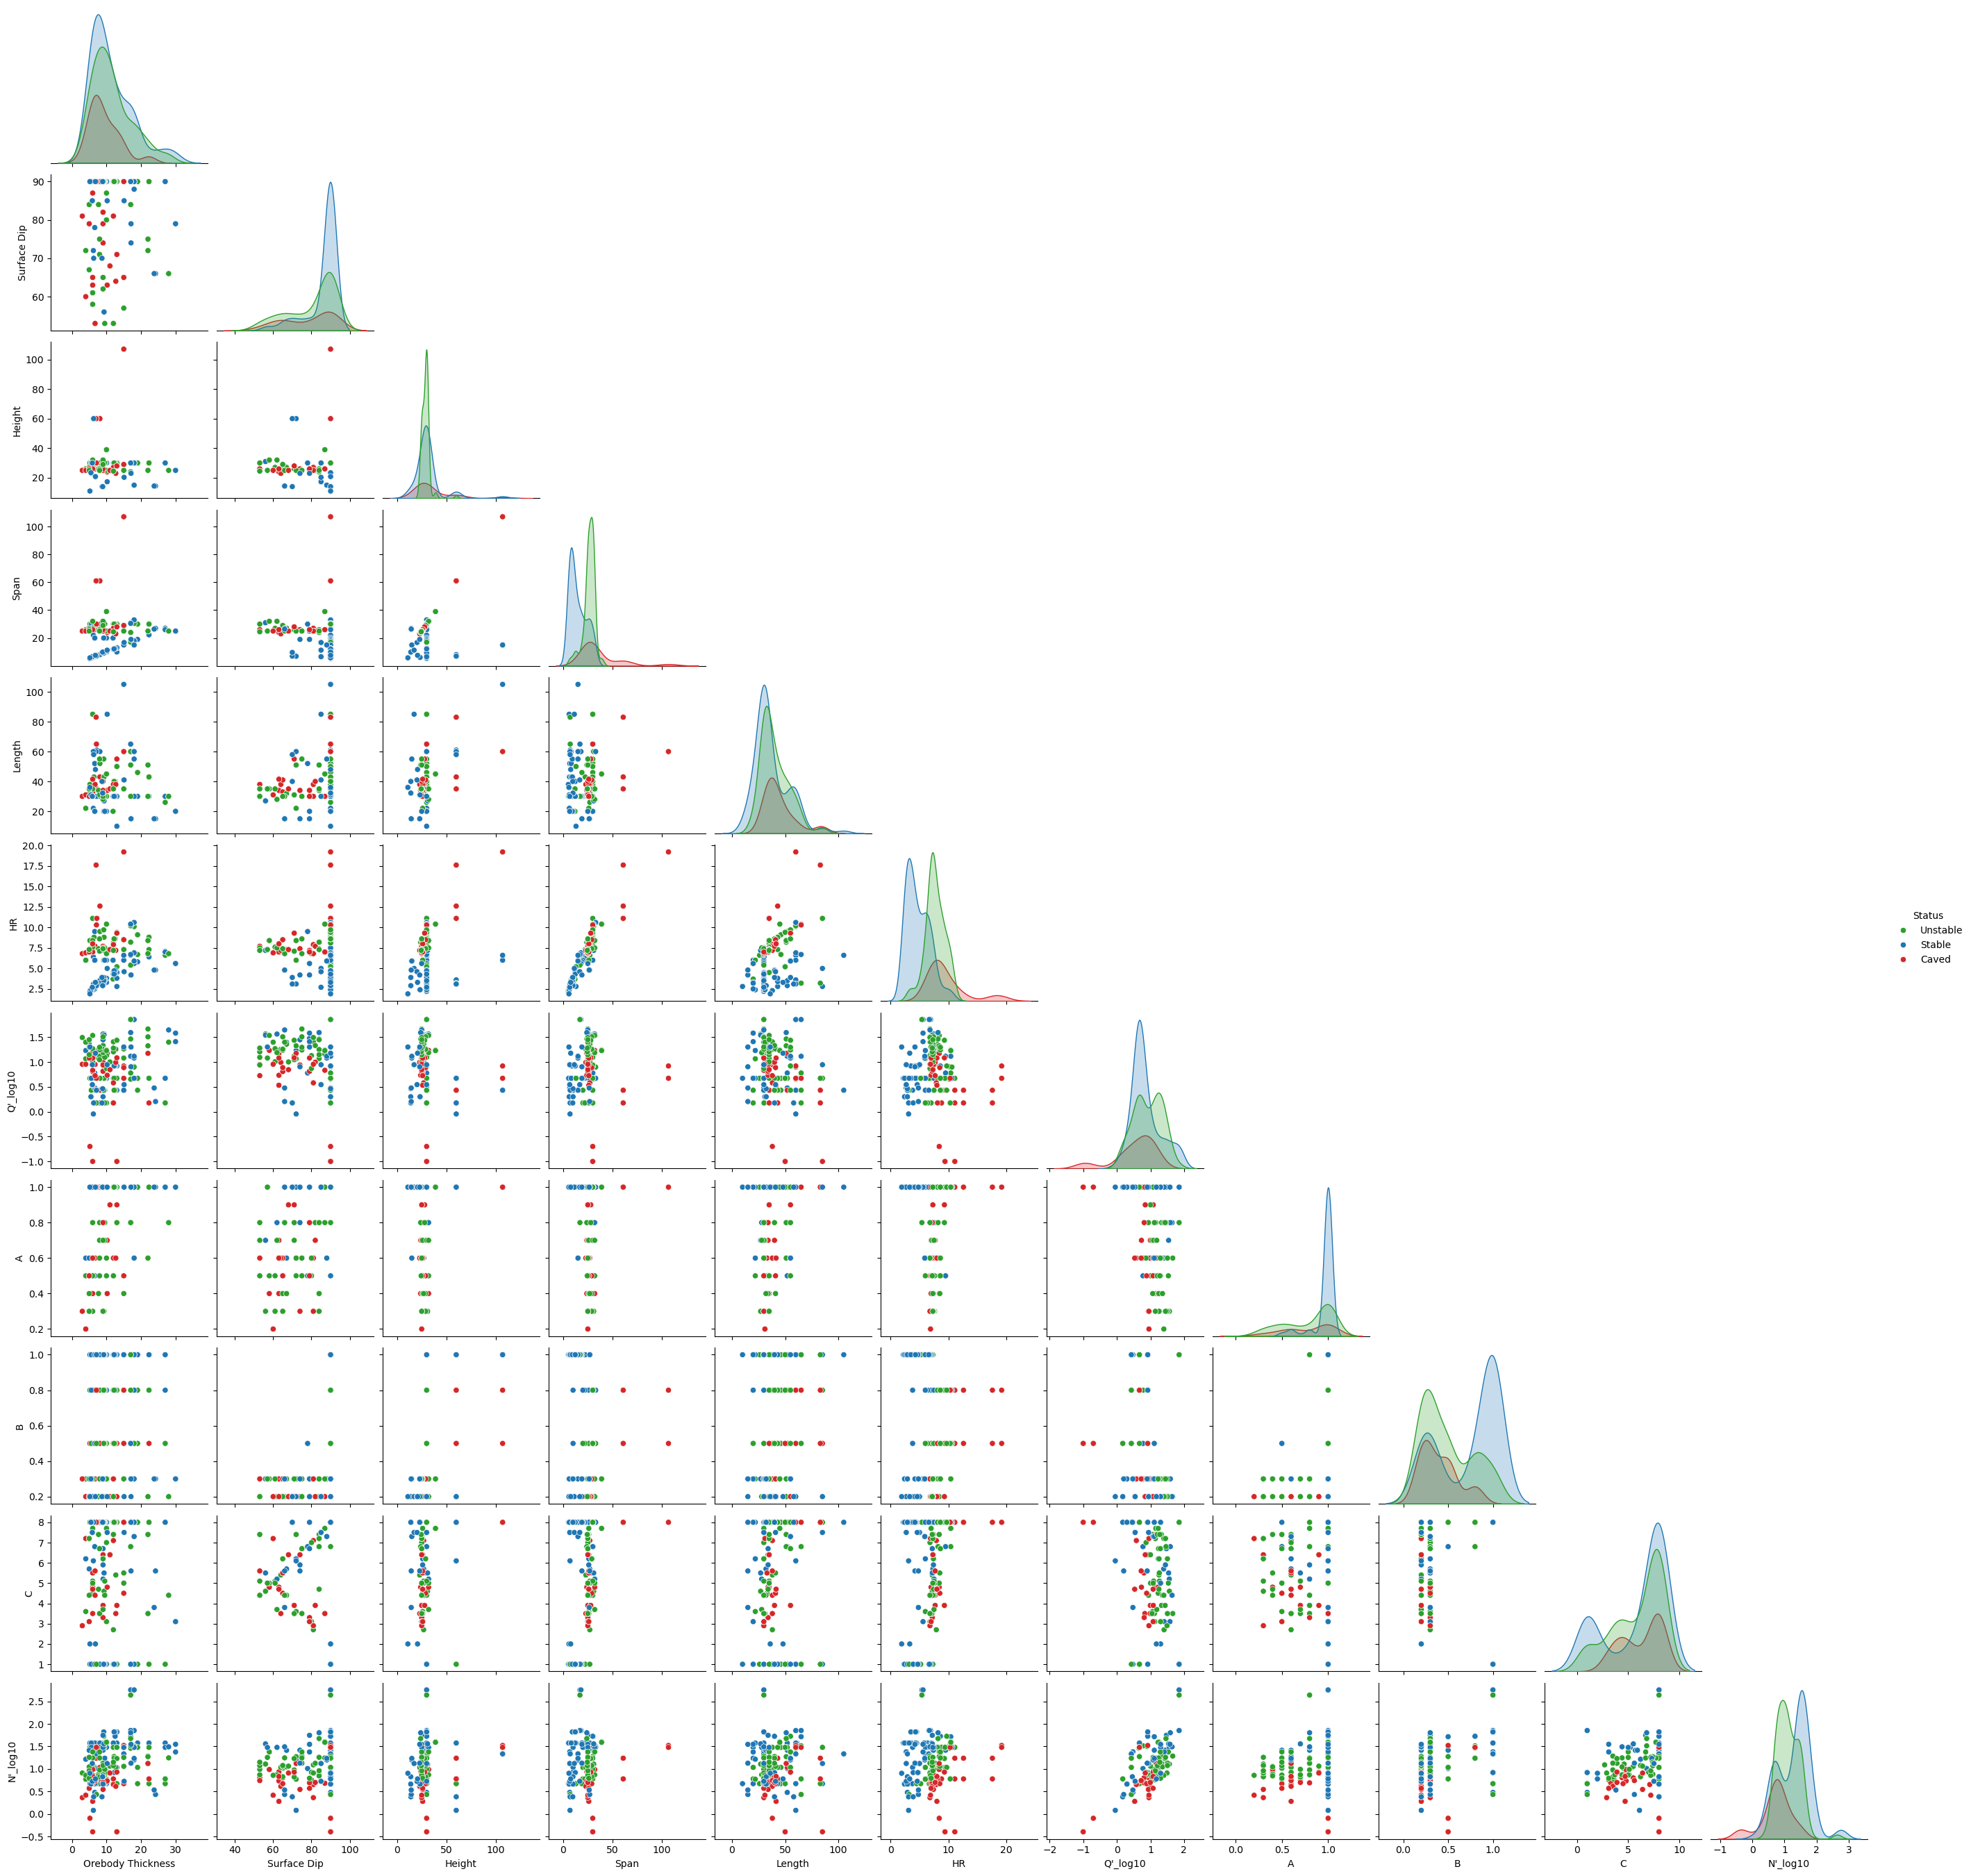

In [6]:
sns.pairplot(data=df[features_quant], hue='Status', palette=custom_palette, corner=True)
plt.plot()

For the sake of re-usability, a plotting function was created, which shows the stability graph and the correspinding frequency of the categorical parameter of choice.

In [7]:
def plot_stability_graph(df, category, palette=None):
    f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 3]))
    
    if palette:
        sns.scatterplot(data=df, x='HR', y="N'_log10", hue=category, palette=palette, ax=axs[0])
        sns.histplot(data=df, x=category, hue=category, shrink=.8, alpha=.8, legend=False, palette=palette, ax=axs[1])
    else:
        sns.scatterplot(data=df, x='HR', y="N'_log10", hue=category, ax=axs[0])
        sns.histplot(data=df, x=category, hue=category, shrink=.8, alpha=.8, legend=False, ax=axs[1])
        
    f.tight_layout()

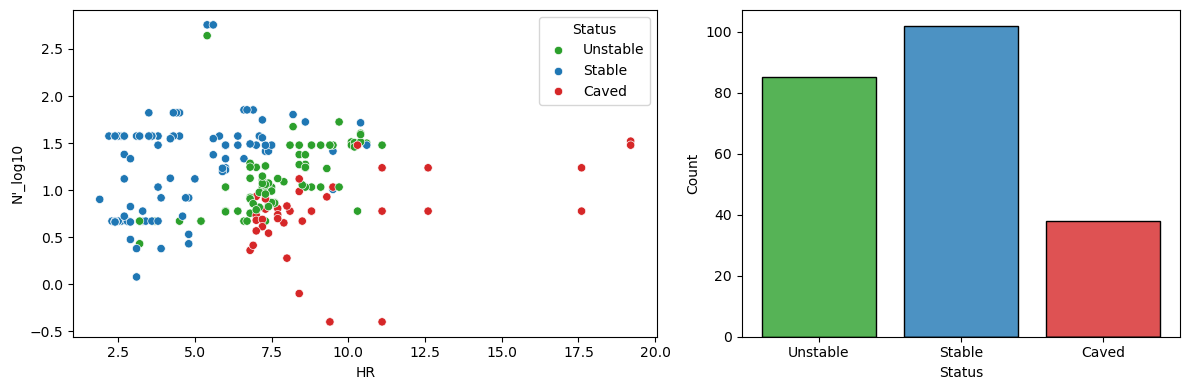

In [8]:
plot_stability_graph(df, 'Status', custom_palette)

Additionally, a contigency-table-based heatmap was created for checking out which categorical features have greater influence on the occurence of each class.

In [9]:
def plot_cont_table(tables, col_labels):
    plt.figure(figsize=(15, 5))

    for i in range(0, len(tables)):
        plt.subplot(1, 3, i+1)
        sns.heatmap(tables[i], annot=True, cmap="viridis")
        plt.title(f"Status vs. {col_labels[i]}")
    
    plt.tight_layout()
    plt.show()

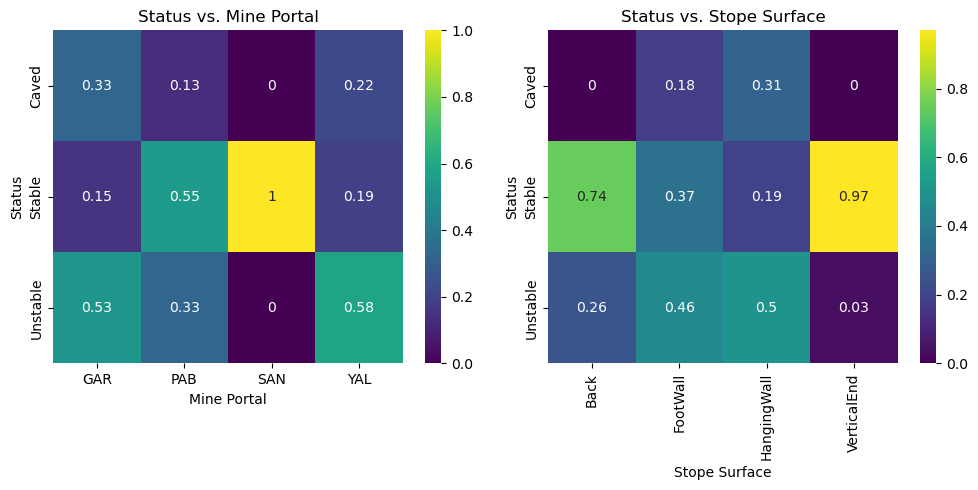

In [10]:
mine_portal_table = pd.crosstab(df['Status'], df['Mine Portal'], normalize='columns')
stope_surface_table = pd.crosstab(df['Status'], df['Stope Surface'], normalize='columns')

tables = [mine_portal_table, stope_surface_table]
col_labels = ['Mine Portal', 'Stope Surface']

plot_cont_table(tables, col_labels)

As suspected, the location (i.e. mining site) has a great inflence of the occurence of each stability class, however, it cannot be used for future predictions, especially for newly-opened mining sites. However, the wall type has an influence, especially the Back-end and Vertical-end wall type. Hence, this can be exploited.

An additional categorical feature which was tested is the level (or depth) which each sample was taken from. However, for a general model this cannot be exploited, but for a site-specific model, this could prove to be useful.

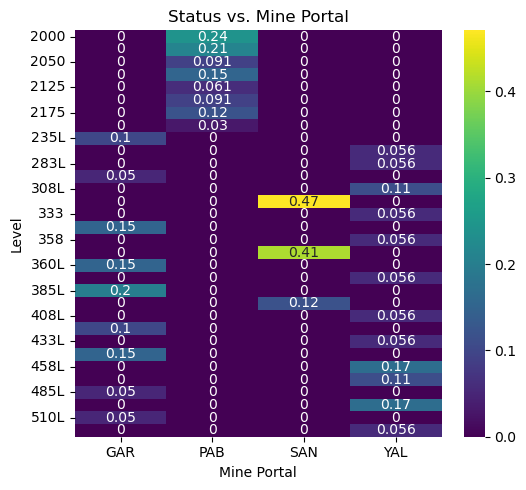

In [11]:
level_table = pd.crosstab(df['Level'], df['Mine Portal'], normalize='columns')
plot_cont_table([level_table], ['Mine Portal'])

Nonetheles, here is a graph, showing what stability classes is each mining site dealing with in its respective conditions.

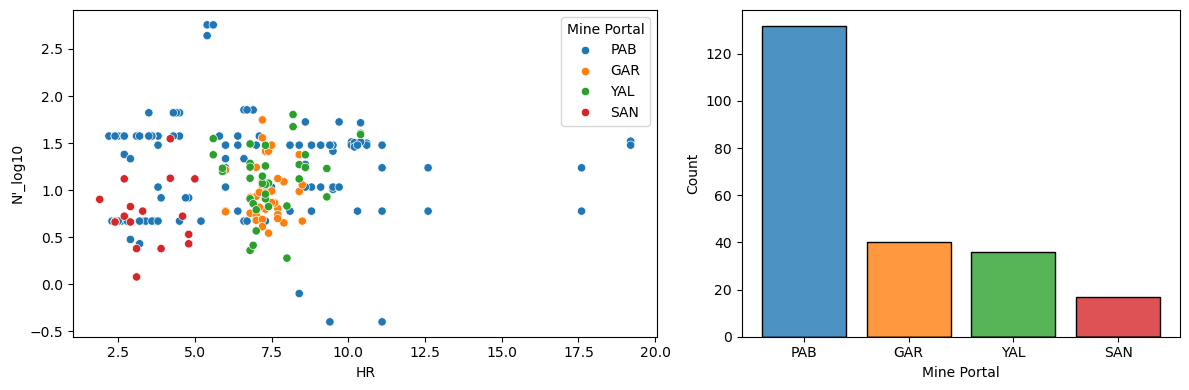

In [12]:
plot_stability_graph(df, 'Mine Portal')

Indeed, wall type definitely inflences stability, as shown on the graph. Further down the notebook, it is used as a predictive feature.

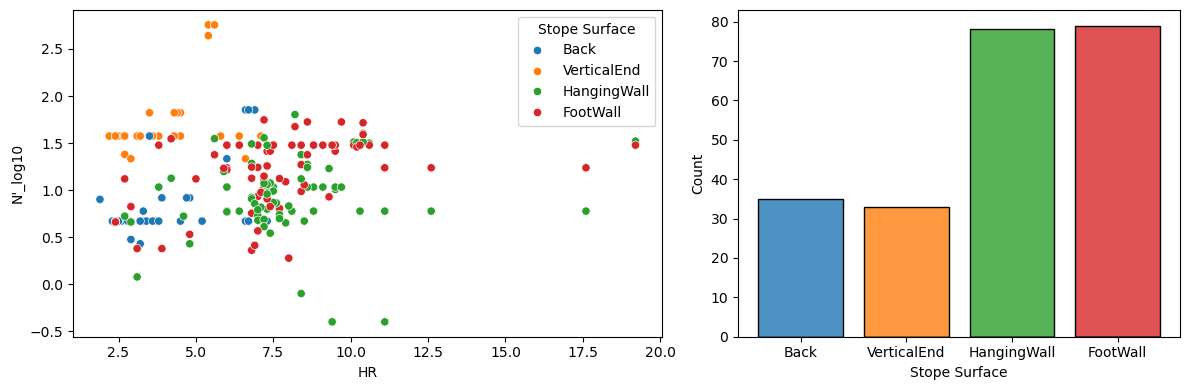

In [13]:
plot_stability_graph(df, 'Stope Surface')

## Training, testing and evaluating exemplary models

Despite that the paper did not used K-fold cross validation, it is applied for this notebook, using 5 folds. It is used for establishing the performance of each model, based on hyper-parameter tuning. The final model evaluation was performed using a Train/Test split with a partition ratio of 0.2 for the Test data.

In [14]:
k_folds = 5
partition = 0.2

A supplementary function was created to plot the learning curve, based on cross validaiton for an arbitrary model.

In [15]:
def plot_learning_curve(model, model_name, X_train, y_train, cv=5):
    train_sizes, train_scores, validation_scores = learning_curve(model,
                                                                  X=X_train,
                                                                  y=y_train,
                                                                  train_sizes=np.linspace(0.1, 1.0, 10),
                                                                  cv=cv,
                                                                  n_jobs=-1
                                                                 )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    
    # Plot learning curves
    plt.figure(figsize=(7, 4))
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='r')
    plt.plot(train_sizes, validation_scores_mean, label='Test score', color='g')
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.1)
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='g', alpha=0.1)
    
    plt.title(f'Learning Curves ({model_name})')
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid()
    
    # plt.savefig(f'MULTICLASS - {model_name} - learning curves.png', bbox_inches='tight')
    
    plt.show()

An additional plotting function was created for plotting the decision boundary of each class via the probability of each class.

In [16]:
def plot_decision_boundary(stopes_df, predictors, target_label, model, model_name):    
    label_1_r = predictors[0]
    label_2_r = predictors[1]
    target_label = 'Status'
        
    class_mapping = {'Stable': 0, 'Unstable': 1, 'Caved': 2}
    
    x_grid = np.arange(-1, 1.1, 0.01)
    y_grid = np.arange(-1, 3, 0.01)
        
    xx, yy = np.meshgrid(x_grid, y_grid)
    
    Z_prob_stable = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,0]
    Z_prob_stable = Z_prob_stable.reshape(xx.shape)
    
    Z_prob_unstable = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z_prob_unstable = Z_prob_unstable.reshape(xx.shape)
    
    Z_prob_caved = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 2]
    Z_prob_caved = Z_prob_caved.reshape(xx.shape)
        
    x_min, x_max = df[label_1_r].min(), df[label_1_r].max()
    y_min, y_max = df[label_2_r].min(), df[label_2_r].max()
    x_grid = x_grid * (x_max - x_min) + x_min
    y_grid = y_grid * (y_max - y_min) + y_min
    xx, yy = np.meshgrid(x_grid, y_grid)
    
    plt.figure(figsize=(7, 4))
    plt.contourf(xx, yy, Z_prob_unstable, levels=np.arange(0.3, 1.1, 0.1), cmap='Blues', alpha=0.3)
    plt.contourf(xx, yy, Z_prob_caved, levels=np.arange(0.3, 1.1, 0.1), cmap='Greens', alpha=0.3)
    plt.contourf(xx, yy, Z_prob_stable, levels=np.arange(0.3, 1.1, 0.1), cmap='Reds', alpha=0.3)
    
    plt.contour(xx, yy, Z_prob_unstable, levels=[0.5], colors='blue', linestyles='--')
    plt.contour(xx, yy, Z_prob_caved, levels=[0.5], colors='green', linestyles='--')
    plt.contour(xx, yy, Z_prob_stable, levels=[0.5], colors='red', linestyles='--')
        
    # Separate and plot data by target label
    stable_df = df[df[target_label] == 'Stable']
    unstable_df = df[df[target_label] == 'Unstable']
    caved_df = df[df[target_label] == 'Caved']
    
    scatter_stable = plt.scatter(stable_df[label_1_r], stable_df[label_2_r], 
                                     facecolor='none', edgecolor='blue', 
                                     marker='o', s=15, label='Stable')
    scatter_unstable = plt.scatter(unstable_df[label_1_r], unstable_df[label_2_r], 
                                      facecolor='none', edgecolor='green', 
                                       marker='^', s=15, label='Unstable')
    scatter_caved = plt.scatter(caved_df[label_1_r], caved_df[label_2_r], 
                                     color='red', marker='x', s=15, label='Caved')
        
    plt.title(f'Decision Boundary - {model_name}')
    plt.xlabel("Hydraulic radius, m")
    plt.ylabel("Modified stability number (N′)")
    
    # Format the axis labels
    def format_func(value, tick_type):
        return f'{10**value:.2f}' if tick_type == 'y' else f'{10**value:.2f}'
        
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_func(y, 'y')))
    plt.legend(loc="lower right")
    
    plt.xlim(0, 20)
    plt.ylim(-1, 3)
    plt.yticks(np.arange(np.log10(0.1), np.log10(1000)+1))

Two metrices were used for alternative model evaluation: Precision and Precision-vs.-Recall AUC.

In [17]:
from sklearn.metrics import make_scorer, precision_score, average_precision_score

precision_macro = make_scorer(precision_score, average='macro', zero_division=0) # Zero division unweighted precision scorer
prec_recall_auc = make_scorer(average_precision_score, response_method="predict_proba") # Precision-Recall AUC scorer

In [18]:
metric = 'f1_macro'

Due to some ill-established train/test splits during the cross validation process and learning curve estimation, warnings for NaN values were muted.

In [19]:
# Surpress warning messages for invalid train/test split partitions
import warnings
from sklearn.exceptions import FitFailedWarning

# Suppress specific UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

### Traditional approach using $HR$ and $\log_{10}N^\prime$

Following the traditional approach of using the two predictors $HR$ and $\log_{10}N^\prime$, several models were evaluated for demonstrative purposes.

In [20]:
predictors = ['HR', "N'_log10"]
target = 'Status'

X = df[predictors].values
y = df[target].values

The data is split using the specified partition ratio. The MinMaxScaler was used only on the training data for mitigating information leek. In addition, all cross validaiton calculations and learning curve estimations were performed on the training set. The test set was used for final evaluation, after training the best model from the cross-validation process on the full training set.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=partition, random_state=42)

In [22]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Softmax model

The Softmax model was used as a smooth-function estimator of the probability of each observation belonging to either of the three classes. A special function was created with the grid space of its hyperparameters. Moreover, a halving random search strategy was applied for finding the best-suited hyperparameters.

In [23]:
def train_cv_lr(df, predictors, target, metric):
    lr = LogisticRegression(multi_class='multinomial')
            
    lr_param_grid = {
    'C': np.arange(0.1, 100.1, 0.1),
    'fit_intercept': [True, False]
    }

    lr_halving_random_search = HalvingRandomSearchCV(lr,
                                                     param_distributions=lr_param_grid,
                                                     factor=5,
                                                     cv=k_folds,
                                                     scoring=metric,
                                                     random_state=42)
    
    lr_halving_random_search.fit(X_train_scaled, y_train)

    return lr_halving_random_search

In [24]:
lr_results = train_cv_lr(df, predictors, target, metric)

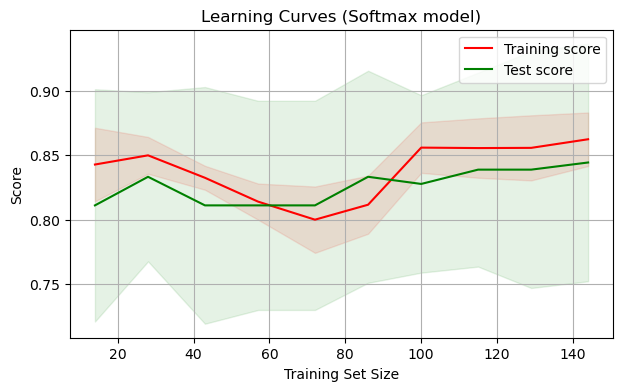

In [25]:
plot_learning_curve(lr_results.best_estimator_, "Softmax model", X_train_scaled, y_train, k_folds)

Based on the learning curve it can be concluded that the training process is successful and that it is highly dependent on more observations.

Another training function is defined, howver, this time for the whole training set, based on the hyperparameters established by the cross-valdiated model.

In [26]:
def train_lr(results):
    lr_parameters = results.best_params_
    lr_model = LogisticRegression(multi_class='multinomial', 
                                  solver='saga', 
                                  # penalty= lr_parameters['penalty'],
                                  C= lr_parameters['C'],
                                  fit_intercept= lr_parameters['fit_intercept'],
                                  random_state=42)
    
    lr_model.fit(X_train_scaled, y_train)

    return lr_model

In [27]:
lr_model = train_lr(lr_results)

The decision boundary established by the model is plotted below.

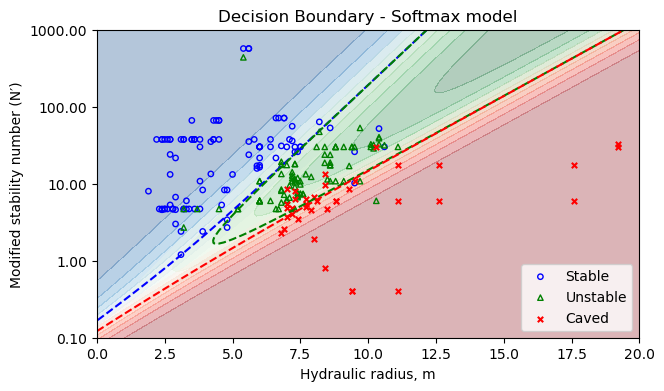

In [28]:
plot_decision_boundary(df, predictors, target, lr_model, "Softmax model")

Based on the used, data, stability graph manages to capture the zone of the Stable class. Interestingly, it diverges from the traditionally established stablity graph plot in the mining-related literature. Nonetheless, does a good job of capturing the peculiarities of the dataset.

In [29]:
lr_y_train_pred = lr_model.predict(X_train_scaled)
lr_y_test_pred = lr_model.predict(X_test_scaled)

In [30]:
lr_train_f1 = f1_score(y_train, lr_y_train_pred, average='macro')
lr_test_f1 = f1_score(y_test, lr_y_test_pred, average='macro')
print(f'Train: {lr_train_f1:.4f}, Test: {lr_test_f1:.4f}')

Train: 0.8588, Test: 0.7580


In [31]:
lr_train_precision = precision_score(y_train, lr_y_train_pred, average='macro', zero_division=0)
lr_test_precision = precision_score(y_test, lr_y_test_pred, average='macro', zero_division=0)
print(f'Train: {lr_train_precision:.4f}, Test: {lr_test_precision:.4f}')

Train: 0.8798, Test: 0.8058


The overall performance of the model can be considered good and it could be used for practical purposes in mine design and preliminary assessemnt of stope stability state.

#### Support vector machine

In [32]:
def train_cv_svc(df, predictors, target, metric):
    svc = SVC(decision_function_shape='ovr', probability=True)
            
    svc_param_grid = {
    'C': np.arange(0.001, 100.001, 0.001),
    'gamma': np.arange(0.001, 1.001, 0.001),
    'kernel': ['rbf', 'sigmoid']
    }

    svc_halving_random_search = HalvingRandomSearchCV(svc,
                                                      param_distributions=svc_param_grid,
                                                      factor=5,
                                                      cv=k_folds,
                                                      scoring=metric,
                                                      random_state=42)
    
    svc_halving_random_search.fit(X_train_scaled, y_train)

    return svc_halving_random_search

In [33]:
svc_results = train_cv_svc(df, predictors, target, metric)

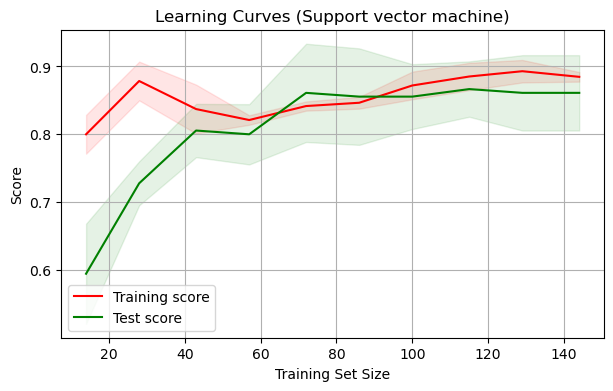

In [34]:
plot_learning_curve(svc_results.best_estimator_, "Support vector machine", X_train_scaled, y_train, k_folds)

In [35]:
def train_svc(results):
    svc_parameters = results.best_params_
    svc_model = SVC(probability = True,
                    C=svc_parameters['C'], 
                    gamma=svc_parameters['gamma'],
                    kernel=svc_parameters['kernel'])
    
    svc_model.fit(X_train_scaled, y_train)

    return svc_model

In [36]:
svc_model = train_svc(svc_results)

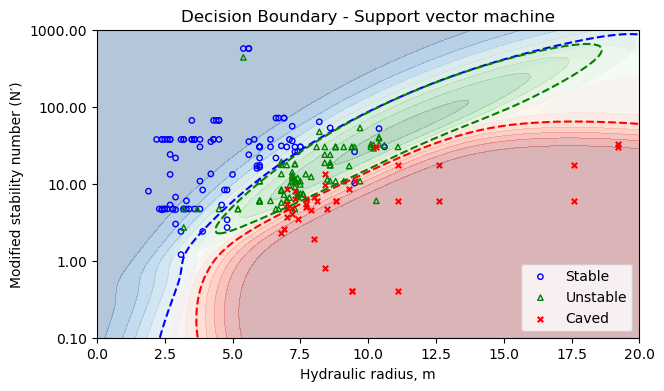

In [37]:
plot_decision_boundary(df, predictors, target, svc_model, "Support vector machine")

In [38]:
svc_y_train_pred = svc_model.predict(X_train_scaled)
svc_y_test_pred = svc_model.predict(X_test_scaled)

In [39]:
svc_train_f1 = f1_score(y_train, svc_y_train_pred, average='macro')
svc_test_f1 = f1_score(y_test, svc_y_test_pred, average='macro')
print(f'Train: {svc_train_f1:.4f}, Test: {svc_test_f1:.4f}')

Train: 0.8863, Test: 0.7919


In [40]:
svc_train_precision = precision_score(y_train, svc_y_train_pred, average='macro', zero_division=0)
svc_test_precision = precision_score(y_test, svc_y_test_pred, average='macro', zero_division=0)
print(f'Train: {svc_train_precision:.4f}, Test: {svc_test_precision:.4f}')

Train: 0.8920, Test: 0.8385


#### Multilayer perceptron

In [41]:
def train_cv_mlp(df, predictors, target, metric):
    mlp = MLPClassifier()
    
    first_layer_neurons = np.arange(10, 105, 5)
    second_layer_neurons = np.arange(10, 105, 5)
    hidden_layer_sizes = list(product(first_layer_neurons, second_layer_neurons))

    mlp_param_grid = {'hidden_layer_sizes': hidden_layer_sizes, 
                      'activation': ['logistic', 'tanh'], 
                      'alpha': np.arange(0.001, 0.1, 0.001),
                      'learning_rate': ['constant', 'invscaling', 'adaptive'], 
                      # 'learning_rate_init': np.arange(0.001, 0.101, 0.001), 
                      'max_iter': [5000]
                     }

    mlp_halving_random_search = HalvingRandomSearchCV(mlp,
                                                      param_distributions = mlp_param_grid,
                                                      factor=3,
                                                      cv=k_folds,
                                                      scoring=metric,
                                                      random_state=42)
    
    mlp_halving_random_search.fit(X_train_scaled, y_train)

    return mlp_halving_random_search

In [42]:
mlp_results = train_cv_mlp(df, predictors, target, metric)

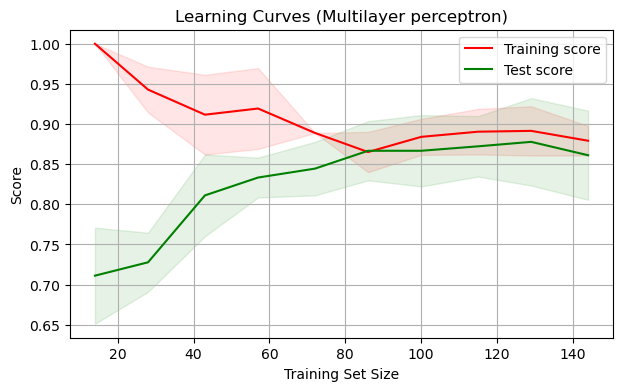

In [43]:
plot_learning_curve(mlp_results.best_estimator_, "Multilayer perceptron", X_train_scaled, y_train, k_folds)

In [44]:
def train_mlp(results):
    mlp_parameters = mlp_results.best_params_
    mlp_model = MLPClassifier(hidden_layer_sizes=mlp_parameters['hidden_layer_sizes'], 
                              activation=mlp_parameters['activation'], 
                              alpha=mlp_parameters['alpha'],
                              learning_rate=mlp_parameters['learning_rate'], 
                              max_iter=mlp_parameters['max_iter'])
    
    mlp_model.fit(X_train_scaled, y_train)

    return mlp_model

In [45]:
mlp_model = train_mlp(mlp_results)

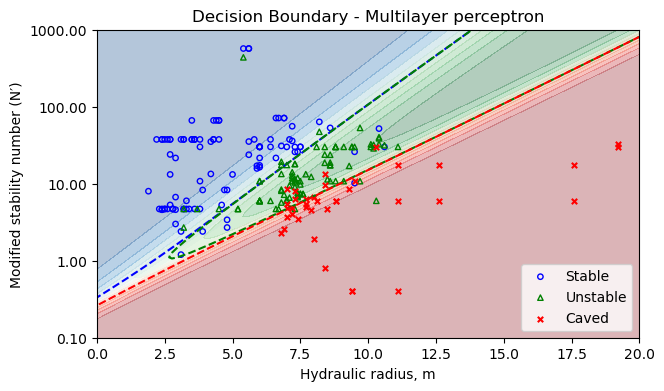

In [46]:
plot_decision_boundary(df, predictors, target, mlp_model, "Multilayer perceptron")

In [47]:
mlp_y_train_pred = mlp_model.predict(X_train_scaled)
mlp_y_test_pred = mlp_model.predict(X_test_scaled)

In [48]:
mlp_train_f1 = f1_score(y_train, mlp_y_train_pred, average='macro')
mlp_test_f1 = f1_score(y_test, mlp_y_test_pred, average='macro')
print(f'Train: {mlp_train_f1:.4f}, Test: {mlp_test_f1:.4f}')

Train: 0.8683, Test: 0.7740


In [49]:
mlp_train_precision = precision_score(y_train, mlp_y_train_pred, average='macro', zero_division=0)
mlp_test_precision = precision_score(y_test, mlp_y_test_pred, average='macro', zero_division=0)
print(f'Train: {mlp_train_precision:.4f}, Test: {mlp_test_precision:.4f}')

Train: 0.8741, Test: 0.8198


#### KNN

In [50]:
def train_cv_knn(df, predictors, target, metric):
    knn = KNeighborsClassifier()
    
    knn_param_grid = {'n_neighbors': np.arange(4, 20, 1),
                      'weights': ['uniform', 'distance'],
                      'metric': ['euclidean'],
                      # 'p': np.arange(1, 10, 0.1)
                     }

    knn_halving_random_search = HalvingRandomSearchCV(knn,
                                                      param_distributions=knn_param_grid,
                                                      factor=3,
                                                      cv=k_folds,
                                                      scoring=metric,
                                                      random_state=42)
    
    knn_halving_random_search.fit(X_train_scaled, y_train)

    return knn_halving_random_search

In [51]:
knn_results = train_cv_knn(df, predictors, target, metric)

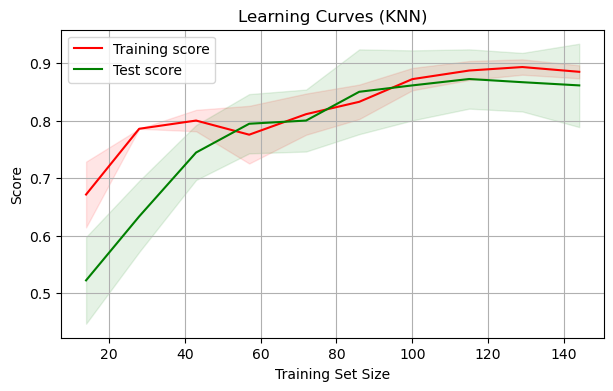

In [52]:
plot_learning_curve(knn_results.best_estimator_, "KNN", X_train_scaled, y_train, cv=k_folds)

It would seem that the training process was sucessful.

In [53]:
def train_knn(results):
    knn_parameters = knn_results.best_params_
    knn_model = KNeighborsClassifier(n_neighbors=knn_parameters['n_neighbors'],
                                     weights=knn_parameters['weights'],
                                     metric=knn_parameters['metric'])
    
    knn_model.fit(X_train_scaled, y_train)

    return knn_model

In [54]:
knn_model = train_knn(knn_results)

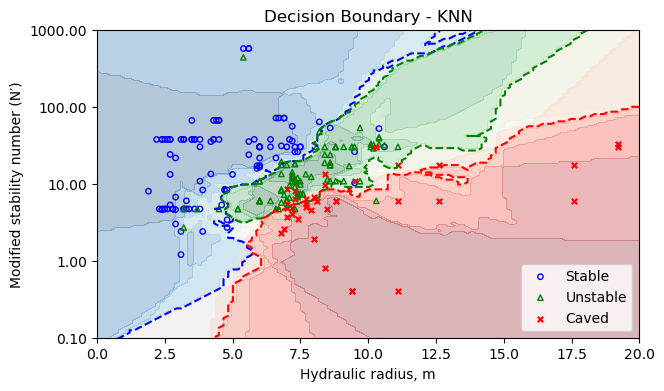

In [55]:
plot_decision_boundary(df, predictors, target, knn_model, "KNN")

The decision surface is decent, as it esentially tries to approximate the boundary, established by the other parametric models.

In [56]:
knn_y_train_pred = knn_model.predict(X_train_scaled)
knn_y_test_pred = knn_model.predict(X_test_scaled)

In [57]:
knn_train_f1 = f1_score(y_train, knn_y_train_pred, average='macro')
knn_test_f1 = f1_score(y_test, knn_y_test_pred, average='macro')
print(f'Train: {knn_train_f1:.4f}, Test: {knn_test_f1:.4f}')

Train: 0.8592, Test: 0.7562


In [58]:
knn_train_precision = precision_score(y_train, knn_y_train_pred, average='macro', zero_division=0)
knn_test_precision = precision_score(y_test, knn_y_test_pred, average='macro', zero_division=0)
print(f'Train: {knn_train_precision:.4f}, Test: {knn_test_precision:.4f}')

Train: 0.8752, Test: 0.8024


KNN throws a good fight, but it would not be sufficinet for practical use cases, where safety is priority.

#### Decision tree

In [59]:
def train_cv_dt(df, predictors, target, metric):
    dt = DecisionTreeClassifier()
    
    dt_param_grid = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': np.arange(2, 11, 1 ),
        'min_samples_split': np.arange(10, 31, 1),
        'min_samples_leaf': np.arange(10, 31, 1)
    }

    dt_halving_random_search = HalvingRandomSearchCV(dt,
                                                     param_distributions=dt_param_grid,
                                                     factor=3,
                                                     cv=k_folds,
                                                     scoring=metric,
                                                     random_state=42)
    
    dt_halving_random_search.fit(X_train_scaled, y_train)

    return dt_halving_random_search

In [60]:
dt_results = train_cv_dt(df, predictors, target, metric)

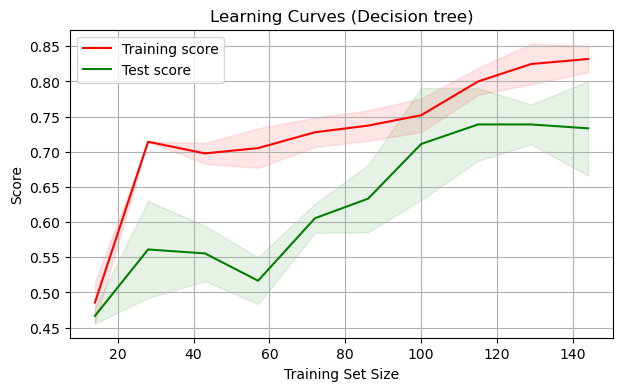

In [61]:
plot_learning_curve(dt_results.best_estimator_, "Decision tree", X_train_scaled, y_train, k_folds)

It would seem that the Decision tree would require more data to build a better model with the established hyperparameters.

In [62]:
def train_dt(results):
    dt_parameters = dt_results.best_params_
    dt_model = DecisionTreeClassifier(criterion=dt_parameters['criterion'],
                                    splitter=dt_parameters['splitter'],
                                    max_depth=dt_parameters['max_depth'],
                                    min_samples_split=dt_parameters['min_samples_split'],
                                    min_samples_leaf=dt_parameters['min_samples_leaf'])
    
    dt_model.fit(X_train_scaled, y_train)

    return dt_model

In [63]:
dt_model = train_dt(dt_results)

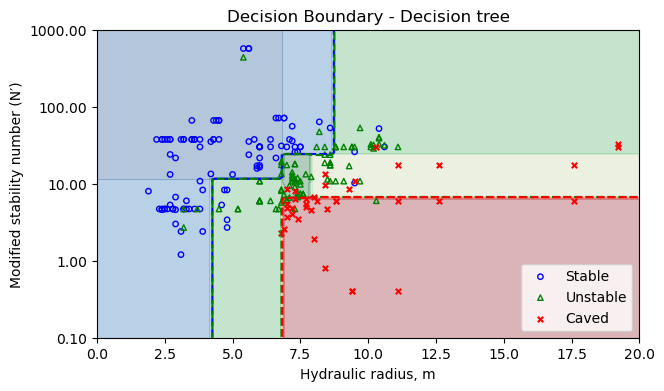

In [64]:
plot_decision_boundary(df, predictors, target, dt_model, "Decision tree")

The decision surface based on the Decision tree stuggles to separate the three classes, but nonetheless, it does a good job.

In [65]:
dt_y_train_pred = dt_model.predict(X_train_scaled)
dt_y_test_pred = dt_model.predict(X_test_scaled)

In [66]:
dt_train_f1 = f1_score(y_train, dt_y_train_pred, average='macro')
dt_test_f1 = f1_score(y_test, dt_y_test_pred, average='macro')
print(f'Train: {dt_train_f1:.4f}, Test: {dt_test_f1:.4f}')

Train: 0.8359, Test: 0.7720


In [67]:
dt_train_precision = precision_score(y_train, dt_y_train_pred, average='macro', zero_division=0)
dt_test_precision = precision_score(y_test, dt_y_test_pred, average='macro', zero_division=0)
print(f'Train: {dt_train_precision:.4f}, Test: {dt_test_precision:.4f}')

Train: 0.8666, Test: 0.7720


Unsurpisingly, the predictive performance of the model is not sufficient for use cases where risk has to be mitigated.

#### Random forests

In [68]:
def train_cv_rf(df, predictors, target, metric):
    rf = RandomForestClassifier()
    
    rf_param_grid = {
        'n_estimators': np.arange(10, 510, 10),
        'max_depth': np.arange(2, 5, 1),
        'max_features': ['sqrt', 'log2'],
        'criterion': ['gini', 'entropy']
    }

    rf_halving_random_search = HalvingRandomSearchCV(rf,
                                                     param_distributions=rf_param_grid,
                                                     factor=5,
                                                     cv=k_folds,
                                                     scoring=metric,
                                                     random_state=42)
    
    rf_halving_random_search.fit(X_train_scaled, y_train)

    return rf_halving_random_search

In [69]:
rf_results = train_cv_rf(df, predictors, target, metric)

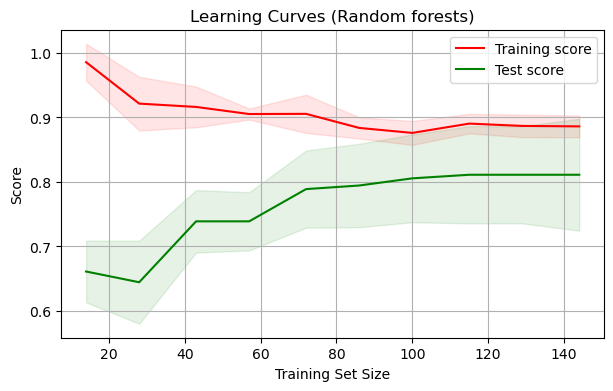

In [70]:
plot_learning_curve(rf_results.best_estimator_, "Random forests", X_train_scaled, y_train, k_folds)

The learning curve indicates that the training process was successful.

In [71]:
def train_rf(results):
    rf_parameters = rf_results.best_params_
    rf_model = RandomForestClassifier(n_estimators=rf_parameters['n_estimators'],
                                      max_depth=rf_parameters['max_depth'],
                                      max_features=rf_parameters['max_features'],
                                      criterion=rf_parameters['criterion'])
    
    rf_model.fit(X_train_scaled, y_train)

    return rf_model

In [72]:
rf_model = train_rf(rf_results)

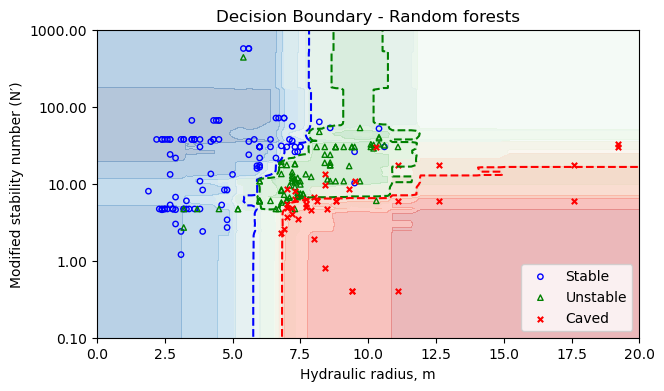

In [73]:
plot_decision_boundary(df, predictors, target, rf_model, "Random forests")

Desptie the edgy decision surface, the models does a decent job at separating the three stability state classes.

In [74]:
rf_y_train_pred = rf_model.predict(X_train_scaled)
rf_y_test_pred = rf_model.predict(X_test_scaled)

In [75]:
rf_train_f1 = f1_score(y_train, rf_y_train_pred, average='macro')
rf_test_f1 = f1_score(y_test, rf_y_test_pred, average='macro')
print(f'Train: {rf_train_f1:.4f}, Test: {rf_test_f1:.4f}')

Train: 0.8494, Test: 0.7964


In [76]:
rf_train_precision = precision_score(y_train, rf_y_train_pred, average='macro', zero_division=0)
rf_test_precision = precision_score(y_test, rf_y_test_pred, average='macro', zero_division=0)
print(f'Train: {rf_train_precision:.4f}, Test: {rf_test_precision:.4f}')

Train: 0.8751, Test: 0.8069


The models seems to do a very good job, regardless of the shape of the decision boundary.

#### Gradient boosted trees

In [77]:
def train_cv_gbt(df, predictors, target, metric):
    gbt = GradientBoostingClassifier()
    
    gbt_param_grid = {
        'loss': ['log_loss'], 
        'learning_rate': np.arange(0.1, 1.1, 0.1), 
        'n_estimators': np.arange(1, 21, 1), 
        'max_depth': np.arange(2, 5, 1), 
    }

    gbt_halving_random_search = HalvingRandomSearchCV(gbt,
                                                     param_distributions = gbt_param_grid,
                                                     factor=5,
                                                     cv=k_folds,
                                                     scoring=metric,
                                                     random_state=42)
    
    gbt_halving_random_search.fit(X_train_scaled, y_train)

    return gbt_halving_random_search

In [78]:
gbt_results = train_cv_gbt(df, predictors, target, metric)

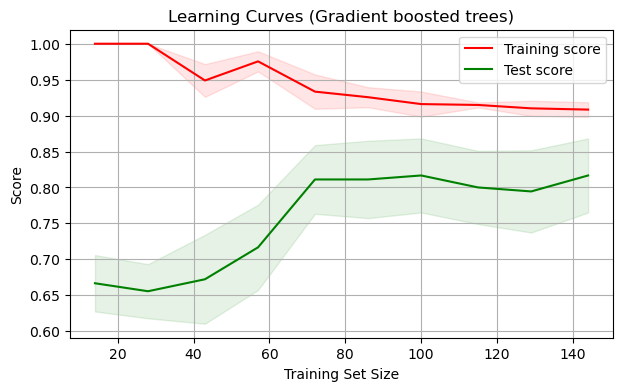

In [79]:
plot_learning_curve(gbt_results.best_estimator_, "Gradient boosted trees", X_train_scaled, y_train, k_folds)

Some overfitting is present for the model, which would require future attention and tuning.

In [80]:
def train_gbt(results):
    gbt_parameters = gbt_results.best_params_
    gbt_model = GradientBoostingClassifier(loss=gbt_parameters['loss'], 
                                           learning_rate=gbt_parameters['learning_rate'], 
                                           n_estimators=gbt_parameters['n_estimators'], 
                                           max_depth=gbt_parameters['max_depth'])
    
    gbt_model.fit(X_train_scaled, y_train)

    return gbt_model

In [81]:
gbt_model = train_gbt(gbt_results)

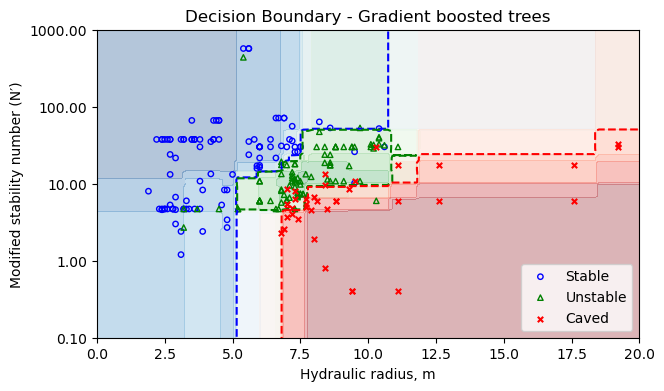

In [82]:
plot_decision_boundary(df, predictors, target, gbt_model, "Gradient boosted trees")

As expected, the deciison surface looks edgu, but it does a decent job at identifying all regions.

In [83]:
gbt_y_train_pred = gbt_model.predict(X_train_scaled)
gbt_y_test_pred = gbt_model.predict(X_test_scaled)

In [84]:
gbt_train_f1 = f1_score(y_train, gbt_y_train_pred, average='macro')
gbt_test_f1 = f1_score(y_test, gbt_y_test_pred, average='macro')
print(f'Train: {gbt_train_f1:.4f}, Test: {gbt_test_f1:.4f}')

Train: 0.9091, Test: 0.8571


In [85]:
gbt_train_precision = precision_score(y_train, gbt_y_train_pred, average='macro', zero_division=0)
gbt_test_precision = precision_score(y_test, gbt_y_test_pred, average='macro', zero_division=0)
print(f'Train: {gbt_train_precision:.4f}, Test: {gbt_test_precision:.4f}')

Train: 0.9329, Test: 0.8879


Interesitngly, the prediction does a near-excellent job.

### Alternative feature combinations

As it was already established through the EDA, the wall type categorical feautre seems to influence the occurence of each class.
Hence, a one-hot-encoding strategy is applied for itroducing it to the classification models.

In [86]:
encoder = OneHotEncoder(sparse_output=False)

encoded = encoder.fit_transform(df[['Stope Surface']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Stope Surface']))

df = pd.concat([df, encoded_df], axis=1)
df.drop('Stope Surface', axis=1, inplace=True)

In [87]:
df.head()

,Mine Portal,Level,Orebody Thickness,Surface Dip,Height,Span,Length,HR,Q',A,...,C,N',Status,Q'_log10,N'_log10,HR_log10,Stope Surface_Back,Stope Surface_FootWall,Stope Surface_HangingWall,Stope Surface_VerticalEnd
0,PAB,2000,11.9,90,30.0,11.9,20.0,3.7,4.7,1.0,...,1.0,4.7,Unstable,0.672098,0.672098,0.568202,1.0,0.0,0.0,0.0
1,PAB,2000,11.9,90,30.0,11.9,30.0,4.3,4.7,1.0,...,8.0,37.6,Stable,0.672098,1.575188,0.633468,0.0,0.0,0.0,1.0
2,PAB,2000,11.9,90,30.0,20.0,30.0,6.0,1.5,1.0,...,8.0,6.0,Unstable,0.176091,0.778151,0.778151,0.0,0.0,1.0,0.0
3,PAB,2000,11.9,90,30.0,20.0,30.0,6.0,4.7,1.0,...,8.0,30.1,Stable,0.672098,1.478566,0.778151,0.0,1.0,0.0,0.0
4,PAB,2000,22.3,90,30.0,22.3,43.0,7.3,4.7,1.0,...,1.0,4.7,Unstable,0.672098,0.672098,0.863323,1.0,0.0,0.0,0.0


A list of tested models (which can potentially be scaled) is established for comparing in different scenarios, applying a diferent set of predictors.

In [88]:
models_list = [
    'Softmax model',
    'Support vector machine',
    'Multilayer perceptron',
    'KNN',
    'Decision tree',
    'Random forests',
    'Gradient boosted trees'
]

A generalized cross validaiton and score writing function is created for simiplicity

In [89]:
def train_cv_models(df, predictors, target, models_list, metric):
    models = {}
    
    for m in models_list:
        if m == 'Softmax model':
            models[m] = train_cv_lr(df, predictors, target, metric)
        elif m == 'Support vector machine':
            models[m] = train_cv_svc(df, predictors, target, metric)
        elif m == 'Multilayer perceptron':
            models[m] = train_cv_mlp(df, predictors, target, metric)
        elif m == 'KNN':
            models[m] = train_cv_knn(df, predictors, target, metric)
        elif m == 'Decision tree':
            models[m] = train_cv_dt(df, predictors, target, metric)
        elif m == 'Random forests':
            models[m] = train_cv_rf(df, predictors, target, metric)
        elif m == 'Gradient boosted trees':
            models[m] = train_cv_gbt(df, predictors, target, metric)

    return models

In [90]:
def write_cv_scores(models_list):
    scores = []
    
    for m in models_list:
        if m == 'Softmax model':
            scores.append(lr_results.best_score_)
        elif m == 'Support vector machine':
            scores.append(svc_results.best_score_)
        elif m == 'Multilayer perceptron':
            scores.append(mlp_results.best_score_)
        elif m == 'KNN':
            scores.append(knn_results.best_score_)
        elif m == 'Decision tree':
            scores.append(dt_results.best_score_)
        elif m == 'Random forests':
            scores.append(rf_results.best_score_)
        elif m == 'Gradient boosted trees':
            scores.append(gbt_results.best_score_)

    return scores

Similarly, a generalized training and score writing function is created for the full training set.

In [91]:
def train_models(cv_models, models_list):
    models = {}
    
    for m in models_list:
        if m == 'Softmax model':
            models[m] = train_lr(cv_models[m])
        elif m == 'Support vector machine':
            models[m] = train_svc(cv_models[m])
        elif m == 'Multilayer perceptron':
            models[m] = train_mlp(cv_models[m])
        elif m == 'KNN':
            models[m] = train_gbt(cv_models[m])
        elif m == 'Decision tree':
            models[m] = train_dt(cv_models[m])
        elif m == 'Random forests':
            models[m] = train_rf(cv_models[m])
        elif m == 'Gradient boosted trees':
            models[m] = train_gbt(cv_models[m])

    return models

In [92]:
def write_scores(models, models_list, X_train, y_train):
    scores = []
    
    for m in models_list:
        cur_model = None
        if m == 'Softmax model':
            cur_model = train_lr(models[m])
        elif m == 'Support vector machine':
            cur_model = train_svc(models[m])
        elif m == 'Multilayer perceptron':
            cur_model = train_mlp(models[m])
        elif m == 'KNN':
            cur_model = train_knn(models[m])
        elif m == 'Decision tree':
            cur_model = train_dt(models[m])
        elif m == 'Random forests':
            cur_model = train_rf(models[m])
        elif m == 'Gradient boosted trees':
            cur_model = train_gbt(models[m])
            
        y_train_pred = cur_model.predict(X_train) 
        train_precision = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
        scores.append(train_precision)

    return scores

#### Traditional approach using $HR$ and $N^\prime$ (i.e. traditional engineered features)

Once more, all models form above are used and trained at the same time in order to compare their results with additional predictive feature combinations.

The cross-validaiton-based model ocne more is applied for following cases, as well as the same scaling strategy is used for the training data, and the applied for the testing data to avoid data leeks.

In [93]:
predictors_trad = ['HR', "N'_log10"]
target = 'Status'

X = df[predictors_trad].values
y = df[target].values
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=partition, random_state=42)

In [94]:
cv_models_trad = train_cv_models(df, predictors_trad, target, models_list, metric)

In [95]:
cv_scores_trad = [cv_models_trad[m].best_score_ for m in models_list]
train_scores_trad = write_scores(cv_models_trad, models_list, X_train_scaled, y_train)
test_scores_trad = write_scores(cv_models_trad, models_list, X_test_scaled, y_test)

#### Model 1 - using additional wall type feature

This scenario serves to show whether an additional one-hot-encoded categorical value, supplementary to the 2D stability graph features can prove to be better for gaining predictive power.

In [96]:
predictors_c1 = ['HR', "N'_log10", 'Stope Surface_VerticalEnd']
target = 'Status'

X = df[predictors_c1].values
y = df[target].values

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=partition, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [98]:
cv_models_c1 = train_cv_models(df, predictors_c1, target, models_list, metric)

In [99]:
cv_scores_c1 = [cv_models_c1[m].best_score_ for m in models_list]
train_scores_c1 = write_scores(cv_models_c1, models_list, X_train_scaled, y_train)
test_scores_c1 = write_scores(cv_models_c1, models_list, X_test_scaled, y_test)

#### Model 2 - using raw predictors (with limited feature engineering)

This scenarios examines the use of only raw predictors without applying additional feature enginerring. The dimensionality of the problem is increased, let's hope it is for the sake of gaining more predictive power.

In [100]:
predictors_c2 = ['HR', "Q'_log10", 'A', 'B', 'C']
target = 'Status'

X = df[predictors_c2].values
y = df[target].values

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=partition, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [102]:
cv_models_c2 = train_cv_models(df, predictors_c2, target, models_list, metric)

In [103]:
cv_scores_c2 = [cv_models_c2[m].best_score_ for m in models_list]
train_scores_c2 = write_scores(cv_models_c2, models_list, X_train_scaled, y_train)
test_scores_c2 = write_scores(cv_models_c2, models_list, X_test_scaled, y_test)

#### Model 3 - using raw predictors and an additional wall type feature

This scenario evaluates the possibility of employing only raw features with a suplementary one-hot-encoded categorical feature, refering to wall type. In this case, the Boolean values which distnguiesh Vertical-end walls from the others. Once more, the dimensionality of the problem is higher than the traditional approach.

In [104]:
predictors_c3 = ['HR', "Q'_log10", 'A', 'B', 'C', 'Stope Surface_VerticalEnd']
target = 'Status'

X = df[predictors_c3].values
y = df[target].values

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=partition, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [106]:
cv_models_c3 = train_cv_models(df, predictors_c3, target, models_list, metric)

In [107]:
cv_scores_c3 = [cv_models_c3[m].best_score_ for m in models_list]
train_scores_c3 = write_scores(cv_models_c3, models_list, X_train_scaled, y_train)
test_scores_c3 = write_scores(cv_models_c3, models_list, X_test_scaled, y_test)

#### Results comparisons

All established training and testing scores were stored in two respective lists for feeding them into plotting functions for simplicity and scalability if additional feature combinations are tests.

In [108]:
train_scores = [
    train_scores_trad, 
    train_scores_c1, 
    train_scores_c2,
    train_scores_c3
]

test_scores = [
    test_scores_trad, 
    test_scores_c1, 
    test_scores_c2,
    test_scores_c3
]

A supplementary function is created to plot all established results for all three modelling approaches, based on different predictors.

In [109]:
def plot_results(scores_list, results_type):
    bar_height = 0.2
    y_positions = np.arange(len(models_list))
    
    plt.figure(figsize=(8, 5))
    plt.barh(y_positions - 1.5*bar_height, scores_list[0], height=bar_height, label='Trad. model', color='tab:blue')
    plt.barh(y_positions - 0.5*bar_height, scores_list[1], height=bar_height, label='Model 1', color='tab:orange')
    plt.barh(y_positions + 0.5*bar_height, scores_list[2], height=bar_height, label='Model 2', color='tab:green')
    plt.barh(y_positions + 1.5*bar_height, scores_list[3], height=bar_height, label='Model 3', color='tab:cyan')
    
    for i, v in enumerate(scores_list[0]):
        plt.text(v + 0.005, y_positions[i] - 1.5*bar_height, f"{v:.3f}", va='center', size=8)
    for i, v in enumerate(scores_list[1]):
        plt.text(v + 0.005, y_positions[i] - 0.5*bar_height, f"{v:.3f}", va='center', size=8)
    for i, v in enumerate(scores_list[2]):
        plt.text(v + 0.005, y_positions[i] + 0.5*bar_height, f"{v:.3f}", va='center', size=8)
    for i, v in enumerate(scores_list[3]):
        plt.text(v + 0.005, y_positions[i] + 1.5*bar_height, f"{v:.3f}", va='center', size=8)
    
    plt.yticks(y_positions, models_list)
    plt.xlabel("Scores")
    plt.title("Model Comparison")
    plt.xlim(0.4, 1.09)
    plt.legend(loc='best', fontsize=7)
    plt.title(results_type)
    
    plt.show()

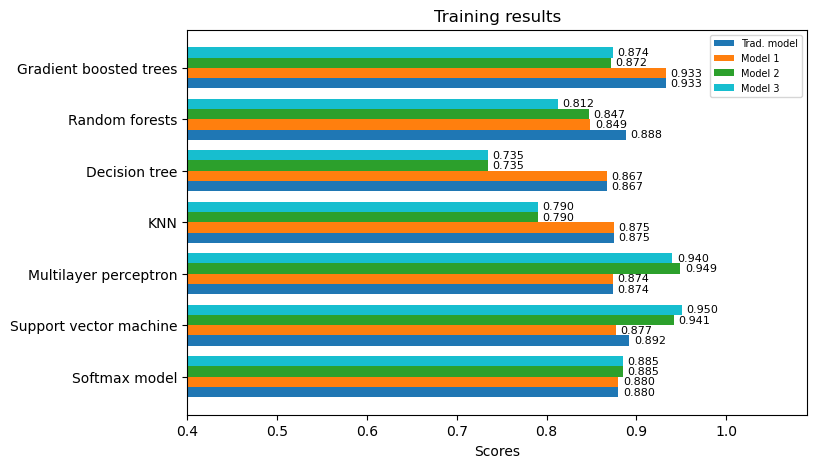

In [110]:
plot_results(train_scores, 'Training results')

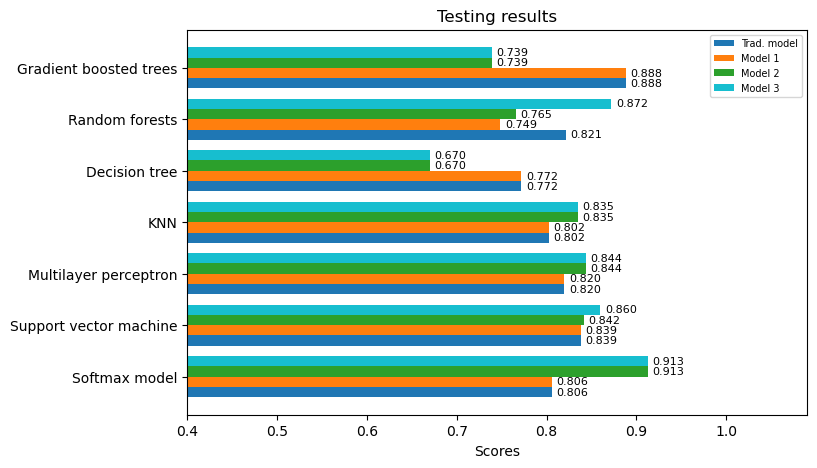

In [111]:
plot_results(test_scores, 'Testing results')

As it can be observed, other alternative models do exist, that perform better than the traditional stability graph. Moreover, additional categorical features, refering to wall type, or other raw features can also be potentially used for creating an improved classification model.

So far, based on the dataset, it does seem that continuous models have a slighly better edge for a future implementation of the predictive models.